# TD2C-D2C, ideas for different MBs (notebook for comparison)
This notebook wants to compare different formulations of `TD2C` method, each of them with a different way of computing the MB:

MB formulations:

1. **Past MB**: Classic TD2C's MB but considering a bigger lag in the past for the variables under exam. Ex: we want to discoveer the causal path X^(t-1)_i -> X_j and normally we would consider X_i^(t-1), X_i^(t), X_i^(t+1) and X_j^(t-1), X_j^(t), X_j^(t+1) but here we ho back in the past and try to include also  X_i^(t-2), X_i^(t-3), X_i^(t-4) and X_j^(t-2), X_j^(t-3), X_j^(t-4) in X_i and X_j's MBs. 
This is done by setting the `past_lag` parameter in the `D2C` class.

2. **TD2C-D2C MIX**: We combine TD2C's MB with a preliminary ranking of the variables as was done in D2C, trying to reduce the computational cost of D2C and maybe find a better balance for the curse of dimentionality.

3. **MBMB**: D2C's MB but enlarged, including the most relevat variables for the most relevant variables for X_i and X_j.


With this notebook you'll be able to generate the data, generate the decriptors for each of the MB formulations, obtain a classification result and plot the results for comparison.


# Settings

## Packages

In [1]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper

## Parameters setting

In [2]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = 60 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [11]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9] # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9]:  # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data'))


P3_N5_Nj2_n0.01 done
P4_N5_Nj2_n0.01 done
P9_N5_Nj2_n0.01 done
P8_N5_Nj2_n0.01 done
P6_N5_Nj2_n0.01 done
P2_N5_Nj2_n0.01 done
P1_N5_Nj2_n0.01 done
P7_N5_Nj2_n0.01 done


18

# Descriptors Generation & Classification

## Regression Estimation of MI

### D2C (& D2C but without contemporaneous nodes) 

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'original',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_R_rocs_process = {}
    d2c_R_precision_process = {}
    d2c_R_recall_process = {}
    d2c_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_R_rocs_process[gen_process_number] = rocs
        d2c_R_precision_process[gen_process_number] = precisions
        d2c_R_recall_process[gen_process_number] = recalls
        d2c_R_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/results/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [4]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/1/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/1 [00:00<?, ?it/s]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node Estimating MB for node1
 Markov Blanket:11 
[6.]Markov Blanket:
 [16.  6.]
Estimating MB for node 1
Estimating MB for nodeMarkov Blanket:  11[6.]

Markov Blanket: [16.  6.]
Estimating MB for node 1Estimating MB for node
 Markov Blanket:10 
[6.]Markov Blanket:
 [15.  5.]
Estimating MB for node Estimating MB for node0 
11Markov Blanket:
 Markov Blanket:[5.] 
[16.  6.]
Estimating MB for node Estimating MB for node1 
5Markov Blanket:
 Markov Blanket:[6.] 
[10.  0.]
Estimating MB for node Estimating MB for node0 
10Markov Blanket:
 Markov Blanket:[5.] 
[15.  5.]
Estimating MB for node Estimating MB for node0
 Markov Blanket:11 
[5.]Markov Blanket:
 [16.  6.]
Estimating MB for nodeEstimating MB for node  17
Estimating MB for node
Markov Blanket:  Markov Blanket:12[6.] 

Markov Blanket:[12.  2.] 
Estimating MB for node[17.  7.]
 Estimating MB for node2 
2Markov Blanket:
 Markov Blanket: [7.][7.]

Estimating MB for node

#### Run Classifier

In [40]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [39]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_R_rocs_process = {}
    td2c_R_precision_process = {}
    td2c_R_recall_process = {}
    td2c_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_R_rocs_process[gen_process_number] = rocs
        td2c_R_precision_process[gen_process_number] = precisions
        td2c_R_recall_process[gen_process_number] = recalls
        td2c_R_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 48)) while a minimum of 1 is required by BalancedRandomForestClassifier.

#### Save Results

In [17]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N10.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N25.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

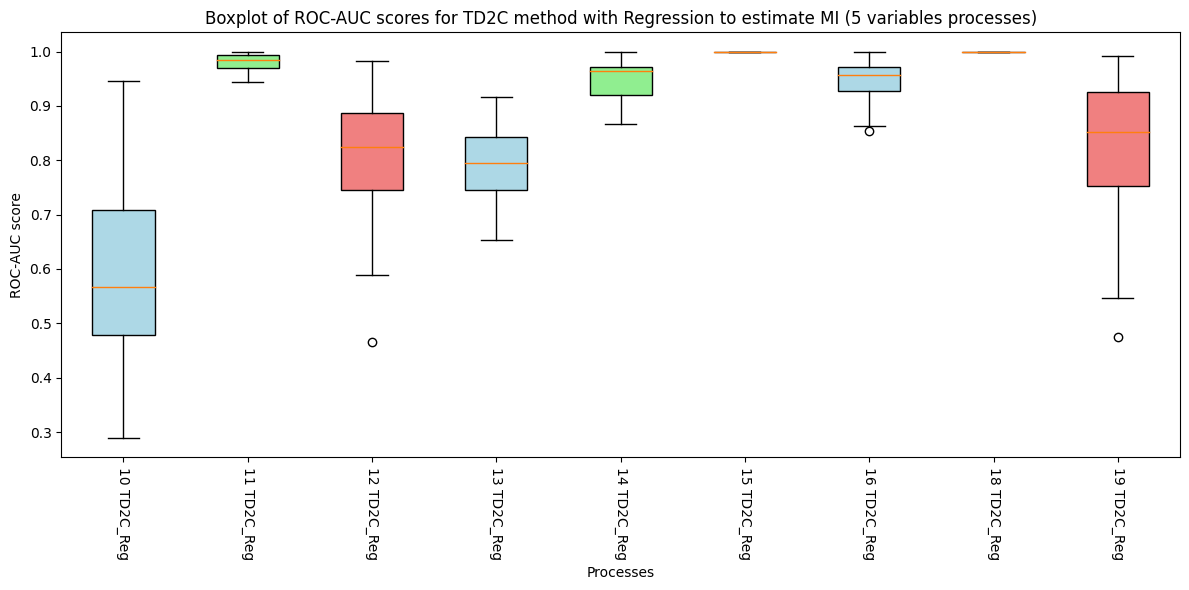

In [18]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(td2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (All methods)

#### Descriptors Generation

In [62]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################

# SET FOLDER
cartella = 4
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3, 
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking

if cartella == 1:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    ts_rank = 'ts_rank'
    vars_to_keep = 1
elif cartella == 11:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 2
elif cartella == 111:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 3
elif cartella == 2:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    ts_rank = 'ts_rank_2'
    vars_to_keep = 1
elif cartella == 3:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    ts_rank = 'ts_rank_3'
    vars_to_keep = 1
elif cartella == 4:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    ts_rank = 'ts_rank_no_cont' 
    vars_to_keep = 1

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= ts_rank,
            top_vars = vars_to_keep)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/8 [00:00<?, ?it/s]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y:

 12%|█▎        | 1/8 [00:13<01:34, 13.53s/it]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: 

 25%|██▌       | 2/8 [00:27<01:23, 13.86s/it]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)


Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)


Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)






Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y:

 38%|███▊      | 3/8 [00:41<01:08, 13.67s/it]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)


Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: 

 50%|█████     | 4/8 [01:10<01:18, 19.70s/it]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)


Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y:

 62%|██████▎   | 5/8 [01:23<00:52, 17.46s/it]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y:

 75%|███████▌  | 6/8 [01:37<00:32, 16.36s/it]

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)



Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)


Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: 

 88%|████████▊ | 7/8 [01:51<00:15, 15.53s/it]

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)


Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)

Shape of X: (245, 25), Shape of Y: (245,)Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: (245,)
Shape of X: (245, 25), Shape of Y: 

100%|██████████| 8/8 [02:19<00:00, 17.49s/it]


#### Run Classifier

In [63]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []

# TAKES THE FOLDER SET AT THE STEP BEFORE AND RUN ALL THE FOLLOWING CELLS FOR THIS METHOD
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking

if cartella == 1:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    name = 'TD2C_+Ranking_1_1_Var'
elif cartella == 11:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    name = 'TD2C_+Ranking_1_2_Var'
elif cartella == 111:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    name = 'TD2C_+Ranking_1_3_Var'
elif cartella == 2:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    name = 'TD2C_+Ranking_2'
elif cartella == 3:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    name = 'TD2C_+Ranking_3'
elif cartella == 4:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    name = 'TD2C+Ranking_NoCont'



# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [64]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file


for n_vars, todo in todos.items():
    m1 = f'{name}_rocs_process'
    m2 = f'{name}_precision_process'
    m3 = f'{name}_recall_process'
    m4 = f'{name}_f1_process'

    globals()[m1] = {}
    globals()[m2] = {}
    globals()[m3] = {}
    globals()[m4] = {}


    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        globals()[m1][gen_process_number] = rocs
        globals()[m2][gen_process_number] = precisions
        globals()[m3][gen_process_number] = recalls
        globals()[m4][gen_process_number] = f1s

 25%|██▌       | 2/8 [00:14<00:43,  7.29s/it]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/

#### Save Results

In [65]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_{name}_N5.pkl'), 'wb') as f:
    everything = (globals()[m1], globals()[m2], globals()[m3], globals()[m4])
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Load data for local and global plots

In [66]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# LOCAL
with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
    globals()[m1], globals()[m2], globals()[m3], globals()[m4] = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# GLOBAL
if cartella == 1:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_1_Var_rocs_process, TD2C_Ranking_1_1_Var_precision_process, TD2C_Ranking_1_1_Var_recall_process, TD2C_Ranking_1_1_Var_f1_process = pickle.load(f)
elif cartella == 11:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_2_Var_rocs_process, TD2C_Ranking_1_2_Var_precision_process, TD2C_Ranking_1_2_Var_recall_process, TD2C_Ranking_1_2_Var_f1_process = pickle.load(f)
elif cartella == 111:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_3_Var_rocs_process, TD2C_Ranking_1_3_Var_precision_process, TD2C_Ranking_1_3_Var_recall_process, TD2C_Ranking_1_3_Var_f1_process = pickle.load(f)
elif cartella == 2:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_2_rocs_process, TD2C_Ranking_2_precision_process, TD2C_Ranking_2_recall_process, TD2C_Ranking_2_f1_process = pickle.load(f)
elif cartella == 3:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_3_rocs_process, TD2C_Ranking_3_precision_process, TD2C_Ranking_3_recall_process, TD2C_Ranking_3_f1_process = pickle.load(f)
elif cartella == 4:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_NoCont_rocs_process, TD2C_Ranking_NoCont_precision_process, TD2C_Ranking_NoCont_recall_process, TD2C_Ranking_NoCont_f1_process = pickle.load(f)

#### Plot

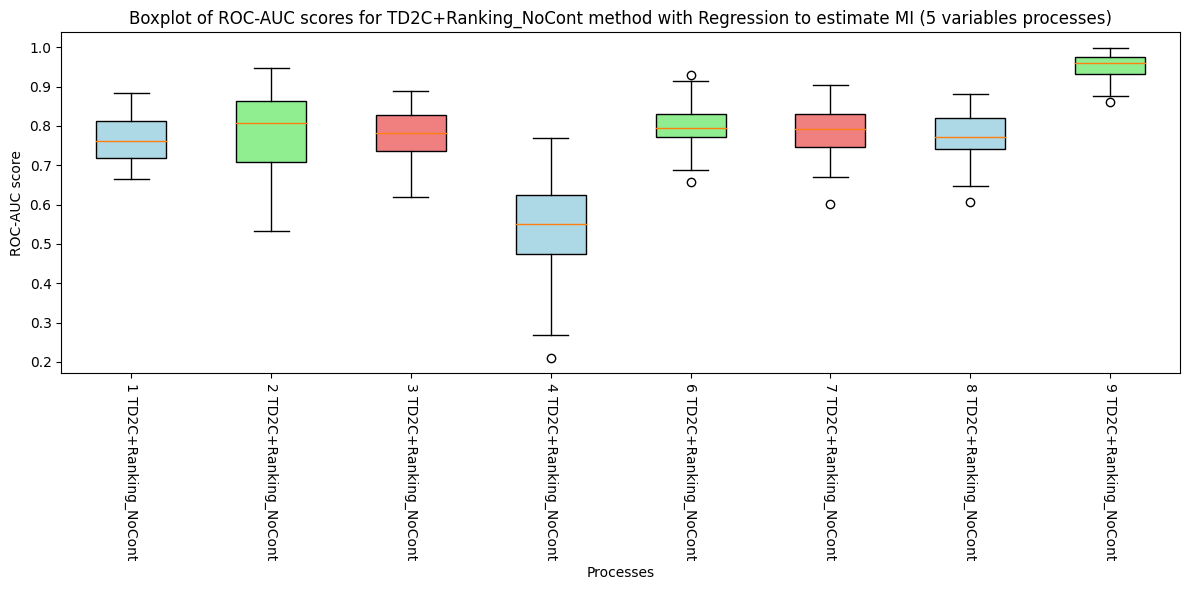

In [68]:
df1 = pd.DataFrame(globals()[m1])
df_name = f'{name}_rocs_dataset'
globals()[df_name] = df1

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} {name}')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title(f'Boxplot of ROC-AUC scores for {name} method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [66]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts_past')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

Estimating MB for node 6Estimating MB for node
 Markov Blanket:6 
[11.  1.]Markov Blanket:Estimating MB for node
 Estimating MB for node  [11.  1.]61


Estimating MB for nodeMarkov Blanket: Markov Blanket: 3Estimating MB for node 
[11.  1.] 
Markov Blanket:[6.]8Estimating MB for node 

[8.] Estimating MB for nodeEstimating MB for node4
Markov Blanket:  
 7Markov Blanket:6 

[13.  3.][9.]Estimating MB for node
Markov Blanket:Markov Blanket:
  Estimating MB for node 8 
[12.  2.]4[11.  1.]Markov Blanket:
 

Estimating MB for nodeEstimating MB for nodeMarkov Blanket:[13.  3.]Estimating MB for node   
 6Estimating MB for node2
1[9.] 
Markov Blanket:1

 Markov Blanket:
 [11.  1.]Markov Blanket:
[7.]Markov Blanket: Estimating MB for node 
[6.] 1

Markov Blanket:[6.] [6.]

Estimating MB for node 8
Markov Blanket: [13.  3.]
Estimating MB for node 48Estimating MB for node
 Markov Blanket:Estimating MB for node  [9.]
6
Estimating MB for nodeMarkov Blanket:
  Markov Blanket:6 
[13.  3.][11.  1.]Ma

  6%|▌         | 1/18 [00:09<02:42,  9.57s/it]

Estimating MB for node Estimating MB for node66 
Estimating MB for nodeMarkov Blanket:
 Markov Blanket:  6[11.  1.]
[11.  1.]
Markov Blanket:
Estimating MB for nodeEstimating MB for node Estimating MB for node  8Estimating MB for node1 [11.  1.]
3

 Estimating MB for nodeEstimating MB for node
Markov Blanket:Markov Blanket:6   Markov Blanket: 
47Estimating MB for node [6.]Markov Blanket:

[13.  3.][8.] 
 Markov Blanket:Markov Blanket:Estimating MB for node

Estimating MB for node  
 
[11.  1.]8[9.][12.  2.] 6Markov Blanket: Estimating MB for nodeEstimating MB for node


4  Estimating MB for node
Markov Blanket:8
Estimating MB for node Markov Blanket:[13.  3.] 1 2 
Markov Blanket:
[11.  1.]8
Estimating MB for nodeMarkov Blanket:[9.] Estimating MB for node

Markov Blanket:
   [13.  3.]Estimating MB for nodeEstimating MB for node Markov Blanket:61[6.] [7.]


6
  
Markov Blanket:Estimating MB for node
Markov Blanket:1Estimating MB for node Estimating MB for nodeMarkov Blanket:[13.  3.] 
  

 11%|█         | 2/18 [01:07<10:06, 37.92s/it]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node 1
Markov Blanket: [6.]
Estimating MB for nodeEstimating MB for nodeEstimating MB for node    111011Estimating MB for node


Markov Blanket: Markov Blanket:Estimating MB for node11Markov Blanket: 
  Markov Blanket:5
 [16.  6.]Markov Blanket:[16.  6.][15.  5.][16.  6.]
 Estimating MB for node


Estimating MB for node[10.  0.]Estimating MB for nodeEstimating MB for node Estimating MB for node 
  1 Estimating MB for node1011
 0

Markov Blanket:
0
Markov Blanket: Markov Blanket:Markov Blanket:
Markov Blanket: [6.]  Markov Blanket: [6.]
Estimating MB for node [6.]
Estimating MB for node[5.][15.  5.] 
[5.] 

117


Estimating MB for nodeMarkov Blanket:Markov Blanket:   0
[12.  2.][16.  6.]
Markov Blanket:
Estimating MB for nodeEstimating MB for nodeEstimating MB for node    121[5.]2


Markov Blanket:
Markov Blanket:  Markov Blanket:[6.] 
[17.  7.][7.]

Estimating MB for nodeEstimating MB for nodeEstimating MB for node  

 17%|█▋        | 3/18 [02:06<11:53, 47.60s/it]

Estimating MB for node  11
Markov Blanket:[16.  6.]Estimating MB for node
Estimating MB for node  [6.] 111

Markov Blanket:Markov Blanket: [16.  6.]

Estimating MB for nodeEstimating MB for node 1 
Markov Blanket:11 
[6.]
Markov Blanket: [16.  6.]
Estimating MB for node 1
Markov Blanket: 
[6.]Estimating MB for nodeEstimating MB for nodeEstimating MB for node  10 5 
Estimating MB for node11
Markov Blanket:  
Markov Blanket:10Markov Blanket:[15.  5.]

 Estimating MB for nodeEstimating MB for nodeMarkov Blanket:  [10.  0.] 110[16.  6.]



Markov Blanket:Markov Blanket:Estimating MB for node[15.  5.] Estimating MB for node  
[5.] [16.  6.]01

Estimating MB for node
Estimating MB for node 
 Markov Blanket:01 Estimating MB for node

Markov Blanket:Estimating MB for nodeMarkov Blanket:[5.]Markov Blanket:    
 [6.]7[6.]12[5.]




Markov Blanket:Markov Blanket:  [12.  2.][17.  7.]

Estimating MB for nodeEstimating MB for nodeEstimating MB for node   272


Markov Blanket:Markov Blanket:Estimatin

 22%|██▏       | 4/18 [02:20<08:01, 34.39s/it]

Estimating MB for node Estimating MB for nodeEstimating MB for nodeEstimating MB for node 6 6
 6Estimating MB for node
8 Markov Blanket:
Estimating MB for nodeEstimating MB for nodeMarkov Blanket:
 6 Markov Blanket: Markov Blanket:
  [11.  1.]87 Estimating MB for nodeMarkov Blanket:
Estimating MB for node
Estimating MB for node  
[11.  1.][11.  1.][13.  3.]Estimating MB for node Markov Blanket: 6

[11.  1.]Markov Blanket: 
8 8
Estimating MB for nodeEstimating MB for nodeEstimating MB for node1Estimating MB for node

 [12.  2.]Estimating MB for nodeMarkov Blanket:
   
 Estimating MB for nodeEstimating MB for nodeMarkov Blanket:
[13.  3.]  Markov Blanket:464 Markov Blanket:  3Estimating MB for node
6 

[11.  1.] 8
 
[13.  3.]1Estimating MB for node
Markov Blanket:Markov Blanket:Estimating MB for node
[13.  3.]
[6.]Markov Blanket:2
 
Markov Blanket:Markov Blanket:  Estimating MB for node  Markov Blanket:Estimating MB for node
1

 Markov Blanket:Estimating MB for node [9.] [9.] [11.  1.]8 

 28%|██▊       | 5/18 [03:17<09:14, 42.63s/it]

Estimating MB for nodeEstimating MB for node 6 Estimating MB for node
6 
Markov Blanket:6 Markov Blanket:
 Markov Blanket:[11.  1.] 
[11.  1.]Estimating MB for node[11.  1.]
 
Estimating MB for node1Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node 
Estimating MB for node   Markov Blanket:3  748 

68

[6.]Markov Blanket:Estimating MB for nodeMarkov Blanket:Markov Blanket:
Markov Blanket:
 
  Estimating MB for nodeMarkov Blanket: [8.]Markov Blanket: 6Estimating MB for node 
[9.] [13.  3.] 
[12.  2.]
[11.  1.]8
 
Markov Blanket:[13.  3.]
8Estimating MB for nodeEstimating MB for node
Estimating MB for node
 Markov Blanket: 
4 Estimating MB for node Estimating MB for nodeEstimating MB for node Markov Blanket:2 6   Markov Blanket:
11
Markov Blanket:[13.  3.]


 6
 Estimating MB for node
[13.  3.][11.  1.]Markov Blanket:
8Estimating MB for nodeEstimating MB for nodeEstimating MB for node 
Markov Blanket:Markov Blanket:Markov Blanket:[9.]
    [7.]  Marko

 33%|███▎      | 6/18 [04:13<09:26, 47.18s/it]

Estimating MB for node 6
Markov Blanket: Estimating MB for node[11.  1.] 6

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeMarkov Blanket:  1  
68Markov Blanket:
[11.  1.]
 Markov Blanket:
 Markov Blanket:Estimating MB for node[6.]  
Estimating MB for node[11.  1.]3

 [13.  3.]Estimating MB for nodeEstimating MB for nodeMarkov Blanket:6
   
4Estimating MB for node[8.]Markov Blanket:7

  
Markov Blanket:4 [11.  1.]Markov Blanket:
[9.] 
Markov Blanket:
Estimating MB for node  [12.  2.]1[9.]

Markov Blanket:
Estimating MB for nodeEstimating MB for nodeEstimating MB for node    [6.]6
82


Markov Blanket: Markov Blanket:Markov Blanket:[11.  1.]  
[7.]Estimating MB for node[13.  3.]
 
1Estimating MB for node
 Estimating MB for nodeMarkov Blanket:Estimating MB for node1   
88[6.]
Markov Blanket:
Markov Blanket:
Markov Blanket:   Estimating MB for node[6.][13.  3.] [13.  3.]

6
Estimating MB for node
Estimating MB for node Markov Blanket: 3 4

Markov Blanket:Markov Blanket: 

 39%|███▉      | 7/18 [04:26<06:34, 35.86s/it]

Estimating MB for node Estimating MB for node 6Estimating MB for node6

 Markov Blanket:Markov Blanket: 6 [11.  1.]Estimating MB for node
[11.  1.]Markov Blanket:Estimating MB for node 

 Estimating MB for node
8 Estimating MB for nodeEstimating MB for node6   [11.  1.]Estimating MB for node
Markov Blanket:7
13  Markov Blanket:

Markov Blanket:Estimating MB for node
 8[13.  3.]Estimating MB for nodeMarkov Blanket: Markov Blanket:
 [11.  1.]
  4 Markov Blanket:Estimating MB for node
Estimating MB for node[12.  2.]6
[8.]Estimating MB for node [6.]
Estimating MB for node 
 Markov Blanket: 

Estimating MB for node [13.  3.]Markov Blanket:8 41 8Estimating MB for node 

[9.]


 2Markov Blanket:[11.  1.]
Markov Blanket:Estimating MB for nodeMarkov Blanket:Estimating MB for nodeMarkov Blanket:6
 
    Markov Blanket:
 Estimating MB for nodeEstimating MB for node[9.]16  [6.]Markov Blanket:Estimating MB for node
 8

[7.]
  [13.  3.][13.  3.]
1Estimating MB for nodeMarkov Blanket:
Markov Blanket:8

 44%|████▍     | 8/18 [05:21<06:59, 41.90s/it]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node 1
Markov Blanket:Estimating MB for nodeEstimating MB for node Estimating MB for nodeEstimating MB for nodeEstimating MB for node[6.]
     11121211
11


Markov Blanket:
 Markov Blanket:Markov Blanket:Markov Blanket:Estimating MB for nodeEstimating MB for nodeMarkov Blanket:      1911

[16.  6.]Markov Blanket:[17.  7.][16.  6.][17.  7.][16.  6.]Markov Blanket:
 


 
Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node[24. 14.] Estimating MB for node[16.  6.]    
 
1211521Estimating MB for nodeEstimating MB for node




 
Markov Blanket: Estimating MB for nodeMarkov Blanket:Markov Blanket:1Markov Blanket:Markov Blanket: Markov Blanket: 2
   17  
[6.]Markov Blanket:[7.]
[6.][7.] 
Markov Blanket:
Markov Blanket:
[6.]
[20. 10.][6.]  


[22. 12.][7.]
Estimating MB for node
Estimating MB for node  20

Markov Blanket: Markov Blanket:[7.] Estimating MB for node
[5.

 50%|█████     | 9/18 [06:20<07:06, 47.37s/it]

Estimating MB for node 11
Markov Blanket:Estimating MB for node  [16.  6.]11

Estimating MB for nodeMarkov Blanket:  1
[16.  6.]Markov Blanket:
 Estimating MB for nodeEstimating MB for node[6.]  
111

Markov Blanket:Markov Blanket:  [6.][16.  6.]

Estimating MB for node 1
Markov Blanket: [6.]
Estimating MB for nodeEstimating MB for nodeEstimating MB for node   105
11


Markov Blanket:Estimating MB for nodeMarkov Blanket: Markov Blanket:  10 Markov Blanket:[10.  0.] 
[15.  5.]Estimating MB for node
Estimating MB for node Estimating MB for node 0Estimating MB for node11 
 
07Markov Blanket:Markov Blanket:

  Markov Blanket:Markov Blanket:[5.]  
[5.]
[15.  5.][16.  6.]

Estimating MB for node Estimating MB for node[12.  2.][16.  6.]0
 

Estimating MB for node1 Markov Blanket:Estimating MB for nodeEstimating MB for node
2  
 Markov Blanket:[5.]112
Markov Blanket: 

 Markov Blanket:[6.]Markov Blanket:[7.]  

[6.][17.  7.]Estimating MB for node

 Estimating MB for node 72

Markov Blanket:Mar

 56%|█████▌    | 10/18 [07:17<06:41, 50.20s/it]

Estimating MB for node 21
Markov Blanket: [26. 16.]Estimating MB for node
Estimating MB for nodeEstimating MB for nodeEstimating MB for node   22 2022
4

Markov Blanket:
Markov Blanket: Markov Blanket: Markov Blanket:  [27. 17.][9.][27. 17.][25. 15.]Estimating MB for node



Estimating MB for node Estimating MB for node Estimating MB for node242  

22Markov Blanket:Markov Blanket:

  Estimating MB for nodeMarkov Blanket:Markov Blanket:[7.][29. 19.] 
  
Estimating MB for node[7.]24[7.] 


4Markov Blanket:Estimating MB for node
  Markov Blanket:20Estimating MB for node 
[29. 19.] [9.]Markov Blanket:
22
 Estimating MB for node
 Markov Blanket:[25. 15.] 4
Estimating MB for node
Estimating MB for node[27. 17.] Markov Blanket: 
2 22
Estimating MB for node[9.] 
Markov Blanket:2
Markov Blanket:Estimating MB for node 
[7.] Markov Blanket: 
 22[7.][27. 17.]


Markov Blanket:Estimating MB for nodeEstimating MB for node   022[27. 17.]


Markov Blanket:Markov Blanket:Estimating MB for node Estimati

 61%|██████    | 11/18 [07:32<04:36, 39.49s/it]

Estimating MB for nodeEstimating MB for node  1111
Estimating MB for node
Markov Blanket: Markov Blanket: 11 [16.  6.]
[16.  6.]
Estimating MB for nodeEstimating MB for nodeMarkov Blanket:
Estimating MB for node  Estimating MB for nodeEstimating MB for node  12 1
[16.  6.] 111
Markov Blanket:Estimating MB for node12Estimating MB for node


Markov Blanket:  Estimating MB for nodeMarkov Blanket:
 Markov Blanket: Estimating MB for node
11 19 [17.  7.] Markov Blanket: [6.]

[6.][16.  6.]1Estimating MB for node 15
Markov Blanket:Markov Blanket:
Estimating MB for node
 

  Estimating MB for node Estimating MB for nodeMarkov Blanket:17Markov Blanket:[24. 14.] [17.  7.]2  
[16.  6.] 

111Markov Blanket:
[6.]
Estimating MB for node[20. 10.]Estimating MB for nodeMarkov Blanket:
 

Estimating MB for nodeEstimating MB for node 
  Markov Blanket:[22. 12.] Markov Blanket: Estimating MB for node2Estimating MB for node17[7.] 
1
2   
Estimating MB for node
[16.  6.]
Markov Blanket:12
0[6.]Estimating MB

 67%|██████▋   | 12/18 [08:31<04:33, 45.54s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for node   11Estimating MB for node1111 


11Markov Blanket:Estimating MB for nodeMarkov Blanket:
Markov Blanket:   Markov Blanket: [16.  6.]12 [16.  6.]

[16.  6.][16.  6.]
Estimating MB for node
Markov Blanket:
Estimating MB for nodeEstimating MB for node Estimating MB for node Estimating MB for nodeEstimating MB for node  1  [17.  7.]1 121Estimating MB for node11

1


 
Markov Blanket:Estimating MB for nodeMarkov Blanket:
Markov Blanket:Markov Blanket:19 Markov Blanket:Estimating MB for node  
  Markov Blanket: [6.] 2Markov Blanket:[6.][6.]
[16.  6.]Estimating MB for node15  


[17.  7.]

 [24. 14.][6.]Markov Blanket:Estimating MB for nodeMarkov Blanket:Estimating MB for node

17 
 Estimating MB for node Estimating MB for node Estimating MB for node1[7.]
  11[20. 10.] 

Markov Blanket:2

217Estimating MB for nodeMarkov Blanket: 
Markov Blanket:
 Estimating MB for node
Markov Blanket:  [22. 12.]Markov Blanket: 12Markov Blanket

 72%|███████▏  | 13/18 [09:30<04:08, 49.66s/it]

Estimating MB for node 11Estimating MB for node
 Markov Blanket:Estimating MB for node11  
[16.  6.]Markov Blanket:11
 
Estimating MB for nodeMarkov Blanket:[16.  6.]  
Estimating MB for node1[16.  6.] Estimating MB for nodeEstimating MB for nodeEstimating MB for node

1Estimating MB for node   Estimating MB for nodeMarkov Blanket:
51011   Markov Blanket:Estimating MB for node


 [6.]110Markov Blanket: Markov Blanket:[6.]Markov Blanket:

 11Estimating MB for node
 
 Markov Blanket:
[10.  0.]Markov Blanket: [15.  5.] Estimating MB for nodeMarkov Blanket:[16.  6.] 
7
 [6.]
 
Estimating MB for node[15.  5.]Estimating MB for nodeEstimating MB for node12Estimating MB for node [16.  6.]
Markov Blanket:
 
  0
Estimating MB for node Estimating MB for node01Markov Blanket:7
Estimating MB for node Estimating MB for node 

  0Estimating MB for nodeMarkov Blanket:
 Markov Blanket:11Markov Blanket:1
 [12.  2.]
  10[17.  7.]Markov Blanket:Markov Blanket: 

[5.]Markov Blanket:

[6.]  [5.]Markov Blank

 78%|███████▊  | 14/18 [10:30<03:30, 52.53s/it]

Estimating MB for node 17
Markov Blanket: Estimating MB for node[22. 12.]
 Estimating MB for node18 
1Markov Blanket:
 Markov Blanket: [6.]Estimating MB for node
[23. 13.] 
Estimating MB for node18 
4Markov Blanket:
Markov Blanket:  [9.][23. 13.]

Estimating MB for node 1
Markov Blanket: [6.]
Estimating MB for nodeEstimating MB for node 7 
18Markov Blanket:
 Estimating MB for nodeMarkov Blanket: [12.  2.] 
 5Estimating MB for node
 [23. 13.]Markov Blanket:2

Markov Blanket:[10.  0.]Estimating MB for node 
 [7.]Estimating MB for node1
 Estimating MB for node
0 Markov Blanket:
6 Markov Blanket:
 [6.]Markov Blanket:[5.]
 
Estimating MB for node 5[11.  1.]

Estimating MB for nodeMarkov Blanket:Estimating MB for node  2 
15[10.  0.]Markov Blanket:

 Markov Blanket:Estimating MB for node[7.]  
0[20. 10.]

Markov Blanket:Estimating MB for node  [5.]0

Markov Blanket: [5.]Estimating MB for node
 17
Markov Blanket: [22. 12.]
Estimating MB for node Estimating MB for node2 
17Markov Blanket: 
[7.

 83%|████████▎ | 15/18 [11:26<02:41, 53.78s/it]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node 1Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node
  Markov Blanket:    1115 1211
1112

[6.]

Markov Blanket:
Markov Blanket:Markov Blanket:
 Estimating MB for nodeMarkov Blanket:Markov Blanket:Markov Blanket:      [16.  6.][20. 10.]19[17.  7.][16.  6.]

[17.  7.]

Estimating MB for node[16.  6.]
Markov Blanket:
Estimating MB for node 
Estimating MB for nodeEstimating MB for node  Estimating MB for node1Estimating MB for node  Estimating MB for node0[24. 14.]Estimating MB for node
  21 

 2Markov Blanket:
15
Estimating MB for node1
Markov Blanket:17 
Markov Blanket: Markov Blanket:
Markov Blanket: 
Markov Blanket:2[6.]   Markov Blanket:
Markov Blanket:[7.] 
Estimating MB for node [6.][5.][7.]Markov Blanket:
  [20. 10.]
[6.] 

11
[22. 12.]
[7.]
Estimating MB for node
Estimating MB for node
Markov Blanket:  Estimating MB for node 17

 89%|████████▉ | 16/18 [12:21<01:48, 54.11s/it]

Estimating MB for node 18
Markov Blanket: [23. 13.]
Estimating MB for node 4
Markov Blanket:Estimating MB for node [9.] 
7
Markov Blanket: Estimating MB for node[12.  2.] 
18Estimating MB for node
 Markov Blanket:4
 Markov Blanket: [23. 13.][9.]

Estimating MB for node 1
Estimating MB for nodeMarkov Blanket:  [6.]Estimating MB for node
18 7

Markov Blanket:Markov Blanket:  [12.  2.]
[23. 13.]Estimating MB for nodeEstimating MB for nodeMarkov Blanket:Markov Blanket:   
25

Estimating MB for node  [7.]1[10.  0.]


Markov Blanket:Estimating MB for node  0[6.]Estimating MB for node

Markov Blanket:  6[5.]

Markov Blanket: 
Estimating MB for node[11.  1.] 5
Estimating MB for nodeMarkov Blanket: Estimating MB for node  215[10.  0.]


Markov Blanket:Markov Blanket:Estimating MB for node  
 Estimating MB for node[7.]0 
[20. 10.]Markov Blanket:
17Estimating MB for nodeEstimating MB for node 
 [5.] 17
Markov Blanket:0

Estimating MB for node Markov Blanket:Markov Blanket:   8[22. 12.][5.]
[22. 1

 94%|█████████▍| 17/18 [12:46<00:45, 45.21s/it]

Estimating MB for node Estimating MB for nodeEstimating MB for node 11 Estimating MB for node11
Estimating MB for node11 Estimating MB for node Markov Blanket:
 
10 11Markov Blanket:5

Markov Blanket:Estimating MB for nodeEstimating MB for node[16.  6.] 
Markov Blanket:Markov Blanket:
   Markov Blanket:  11Estimating MB for node[16.  6.]10Estimating MB for node[16.  6.] [15.  5.]
[16.  6.]

Estimating MB for node  

Markov Blanket:Estimating MB for node[10.  0.]Estimating MB for node
Markov Blanket: 1Estimating MB for node7   Estimating MB for nodeEstimating MB for node
 12
 
1Estimating MB for nodeEstimating MB for node7[16.  6.]  Markov Blanket:Estimating MB for node
[15.  5.]1
Markov Blanket:
0
  1  
Markov Blanket:Markov Blanket: 
Markov Blanket:Estimating MB for node
Estimating MB for node[6.]
100  Markov Blanket:11Estimating MB for node[12.  2.]Markov Blanket: Estimating MB for node Estimating MB for node
Markov Blanket: 

[17.  7.] [6.] 

 [12.  2.] 7 1 Markov Blanket:Markov Bla

100%|██████████| 18/18 [13:44<00:00, 45.83s/it]


#### Run Classifier

In [67]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [68]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_R_rocs_process = {}
    td2c_past_R_precision_process = {}
    td2c_past_R_recall_process = {}
    td2c_past_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_R_rocs_process[gen_process_number] = rocs
        td2c_past_R_precision_process[gen_process_number] = precisions
        td2c_past_R_recall_process[gen_process_number] = recalls
        td2c_past_R_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Save Results

In [69]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_R_N5.pkl'), 'wb') as f:
    everything = (td2c_past_R_rocs_process, td2c_past_R_precision_process, td2c_past_R_recall_process, td2c_past_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

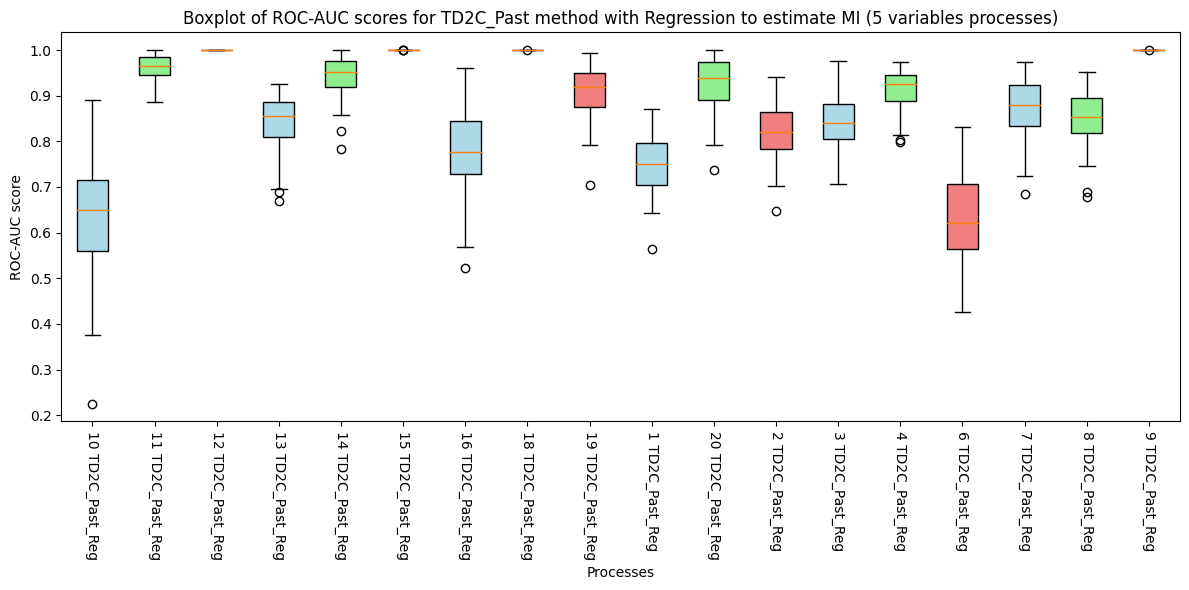

In [70]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    td2c_past_R_rocs_process, td2c_past_R_precision_process, td2c_past_R_recall_process, td2c_past_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(td2c_past_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Past_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_Past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

## KNNCMI Estimation of MI

### D2C (& D2C but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'original')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_K_rocs_process = {}
    d2c_K_precision_process = {}
    d2c_K_recall_process = {}
    d2c_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_K_rocs_process[gen_process_number] = rocs
        d2c_K_precision_process[gen_process_number] = precisions
        d2c_K_recall_process[gen_process_number] = recalls
        d2c_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_K_rocs_process = {}
    td2c_K_precision_process = {}
    td2c_K_recall_process = {}
    td2c_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_K_rocs_process[gen_process_number] = rocs
        td2c_K_precision_process[gen_process_number] = precisions
        td2c_K_recall_process[gen_process_number] = recalls
        td2c_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (& TD2C + Ranking but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run CLassifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rank_K_rocs_process = {}
    td2c_rank_K_precision_process = {}
    td2c_rank_K_recall_process = {}
    td2c_rank_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rank_K_rocs_process[gen_process_number] = rocs
        td2c_rank_K_precision_process[gen_process_number] = precisions
        td2c_rank_K_recall_process[gen_process_number] = recalls
        td2c_rank_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_rank_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_rank_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_rank method with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_Past/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_K_rocs_process = {}
    td2c_past_K_precision_process = {}
    td2c_past_K_recall_process = {}
    td2c_past_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_K_rocs_process[gen_process_number] = rocs
        td2c_past_K_precision_process[gen_process_number] = precisions
        td2c_past_K_recall_process[gen_process_number] = recalls
        td2c_past_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores fro TD2C_past method with knnCMI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

# Plot all Results - Comparison

### ROC-AUC

#### Regression

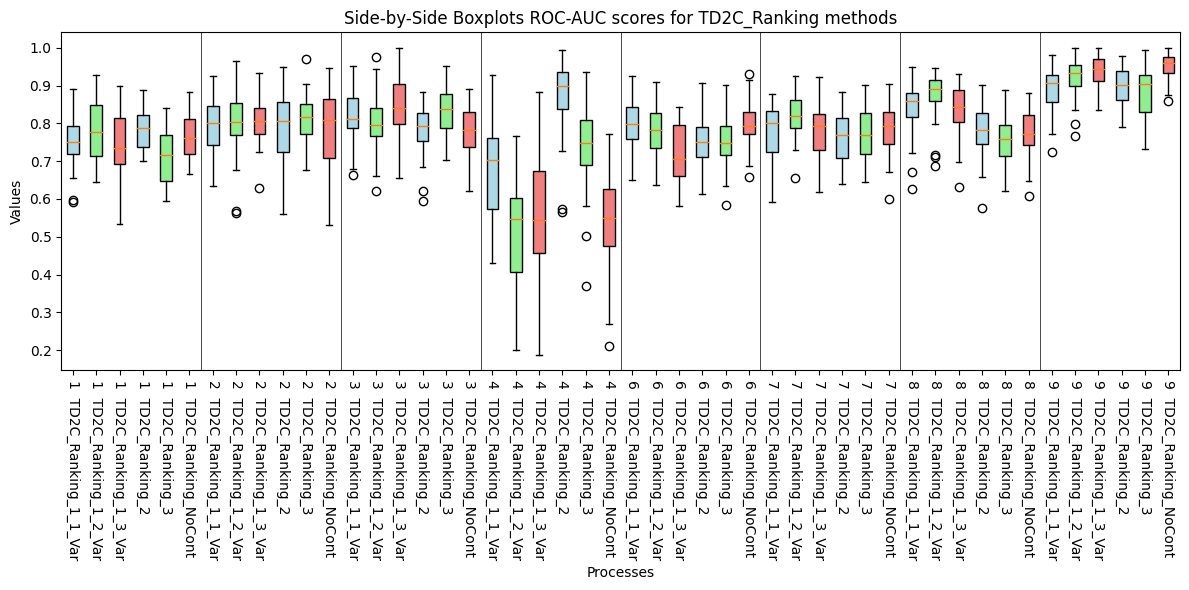

In [105]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
df4 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots ROC-AUC scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(6, len(labels), 6):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking.pdf')

plt.show()

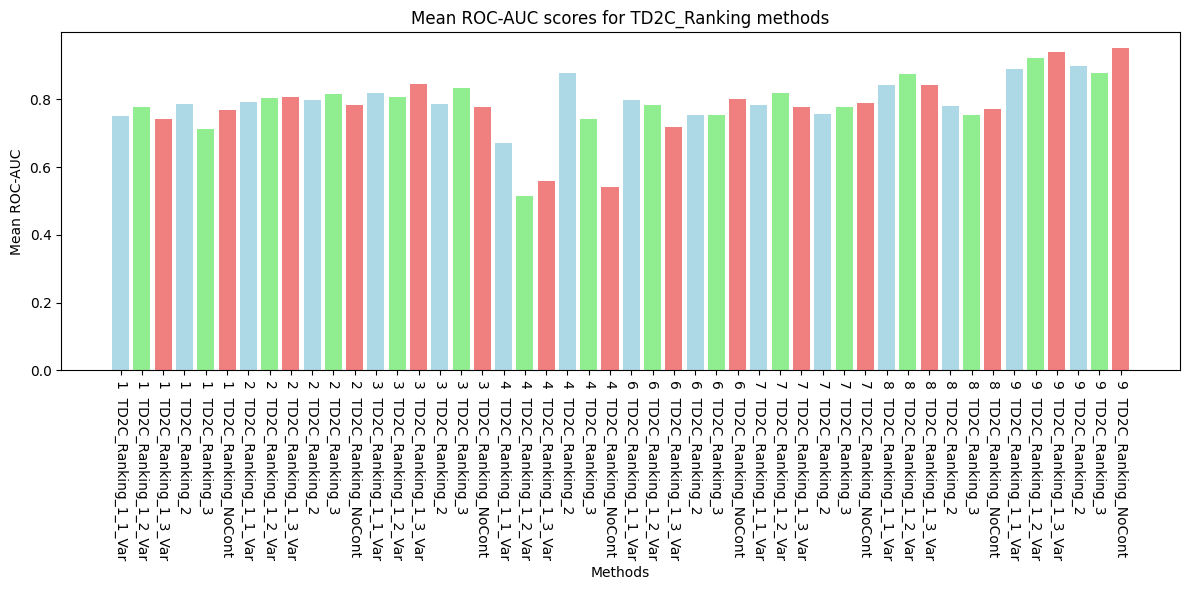

In [76]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))
plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking.pdf')

plt.show()

In [107]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
df4 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_2'
df5['method'] = 'TD2C_Ranking_3'
df6['method'] = 'TD2C_Ranking_NoCont'

df = pd.concat([df1, df2, df3, df4, df5, df6])

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='roc_auc')

df['roc_auc'] = df['roc_auc'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='roc_auc')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_rocs_process': 'TD2C_+Ranking_1_1_Var_rocs_process', 
                        'TD2C_+Ranking_1_2_Var_rocs_process': 'TD2C_+Ranking_1_2_Var_rocs_process', 
                        'TD2C_+Ranking_1_3_Var_rocs_process': 'TD2C_+Ranking_1_3_Var_rocs_process', 
                        'TD2C_+Ranking_2_rocs_process': 'TD2C_+Ranking_2_rocs_process', 
                        'TD2C_+Ranking_3_rocs_process': 'TD2C_+Ranking_3_rocs_process', 
                        'TD2C_+Ranking_NoCont_rocs_process': 'TD2C_+Ranking_NoCont_rocs_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/roc_auc_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_1545/2175215387.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  \
0                1              0.751105              0.776867   
1                2              0.792217              0.802992   
2                3              0.819319              0.806345   
3                4              0.670670              0.514556   
4                6              0.796935              0.783728   
5                7              0.783013              0.819597   
6                8              0.843509              0.876092   
7                9              0.890083              0.921609   

method  TD2C_Ranking_1_3_Var  TD2C_Ranking_2  TD2C_Ranking_3  \
0                   0.742947        0.786904        0.711914   
1                   0.808042        0.796670        0.814817   
2                   0.844077        0.786553        0.833507   
3                   0.557843        0.878195        0.742113   
4                   0.717066        0.752642        0.754752   
5                   0.778058        0.758128        0.776837   
6                   0.843181        0.780358        0.753117   
7                   0.939776        0.897223        0.879061   

method  TD2C_Ranking_NoCont  
0                  0.767333  
1                  0.783756  
2                  0.777334  
3                  0.541170  
4                  0.800364  
5                  0.789118  
6                  0.772224  
7                  0.950101

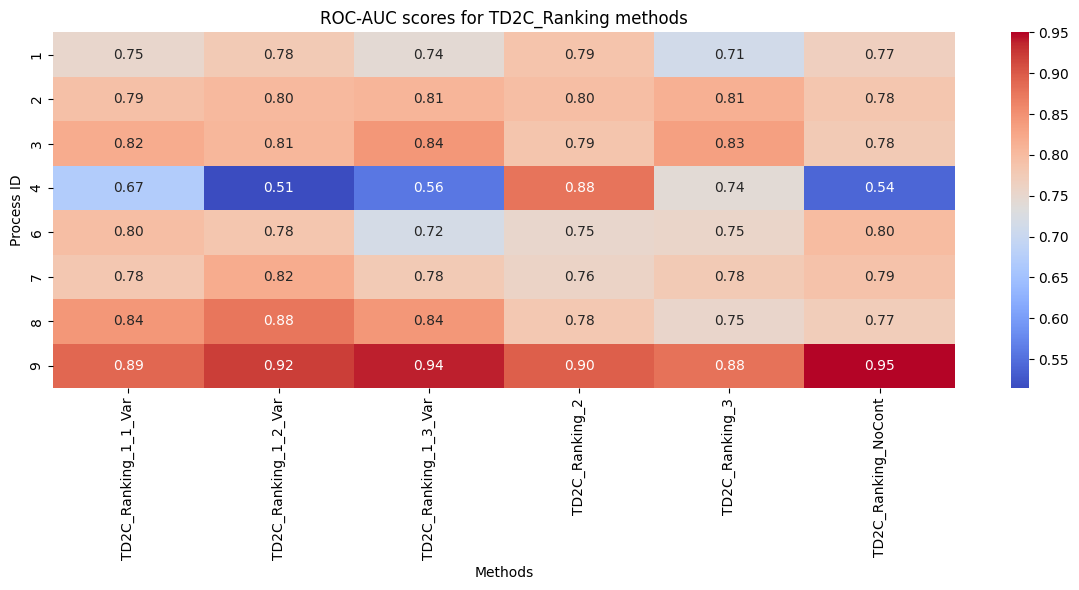

In [108]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/roc_auc_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('ROC-AUC scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking.pdf')

plt.show()

In [144]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/roc_auc_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'roc_auc'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/roc_auc_td2c_ranking_mean_proc.csv', index=False)

df

Process ID   roc_auc
0           1  0.756178
1           2  0.799749
2           3  0.811189
3           4  0.650758
4           6  0.767581
5           7  0.784125
6           8  0.811414
7           9  0.912975

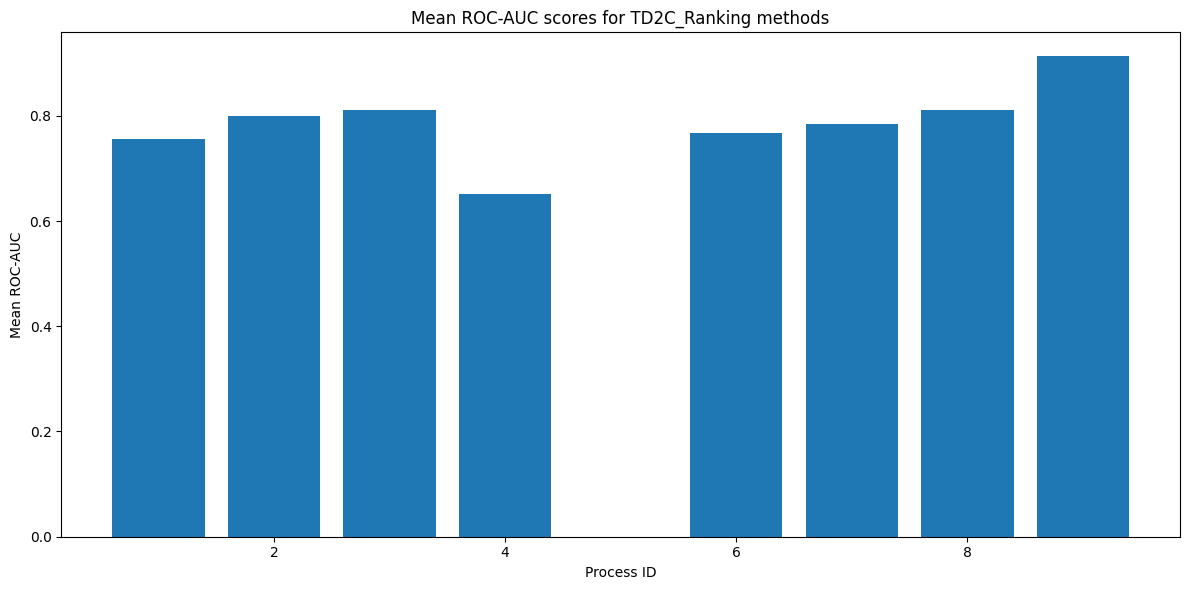

In [145]:
# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['roc_auc'])
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [85]:
# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'roc_auc'})

df = df.sort_values(by='roc_auc', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/roc_auc_td2c_ranking_avg.csv', index=False)

df

method   roc_auc
0            Process ID  5.000000
1        TD2C_Ranking_2  0.804584
2  TD2C_Ranking_1_1_Var  0.793356
3  TD2C_Ranking_1_2_Var  0.787723
4        TD2C_Ranking_3  0.783265
5  TD2C_Ranking_1_3_Var  0.778874
6   TD2C_Ranking_NoCont  0.772675

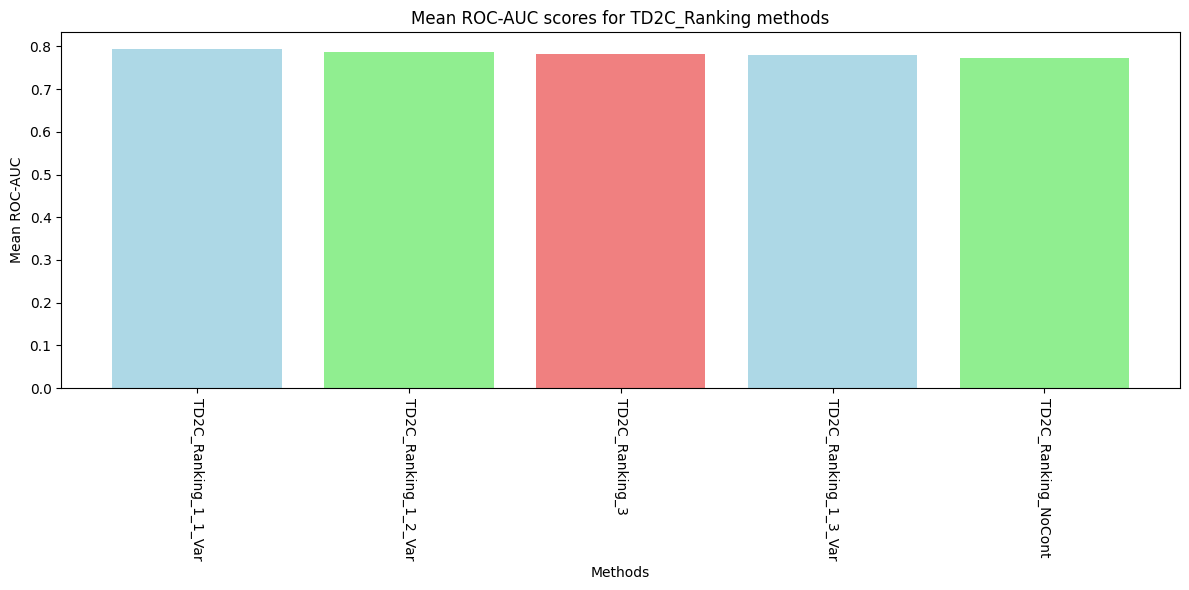

In [103]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/roc_auc_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'][1:], df['roc_auc'][1:], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_avg.pdf')

plt.show()

#### knnCMI

In [ ]:
import matplotlib.pyplot as plt

df1 = pd.DataFrame(d2c_K_rocs_process)
df2 = pd.DataFrame(td2c_K_rocs_process)
df3 = pd.DataFrame(td2c_rank_K_rocs_process)
# df4 = pd.DataFrame(td2c_past_K_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for ROC-AUC scores for D2C, TD2C and TD2C+Ranking methods with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

### Precision

#### Regression

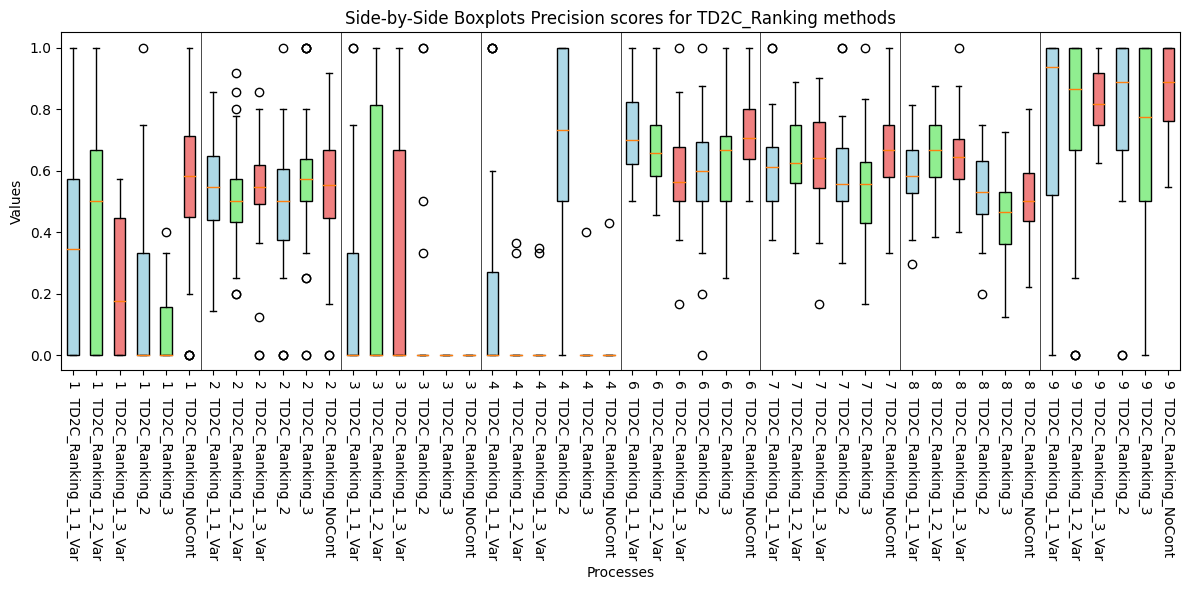

In [86]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
df4 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(6, len(labels), 6):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking_precision.pdf')

plt.show()

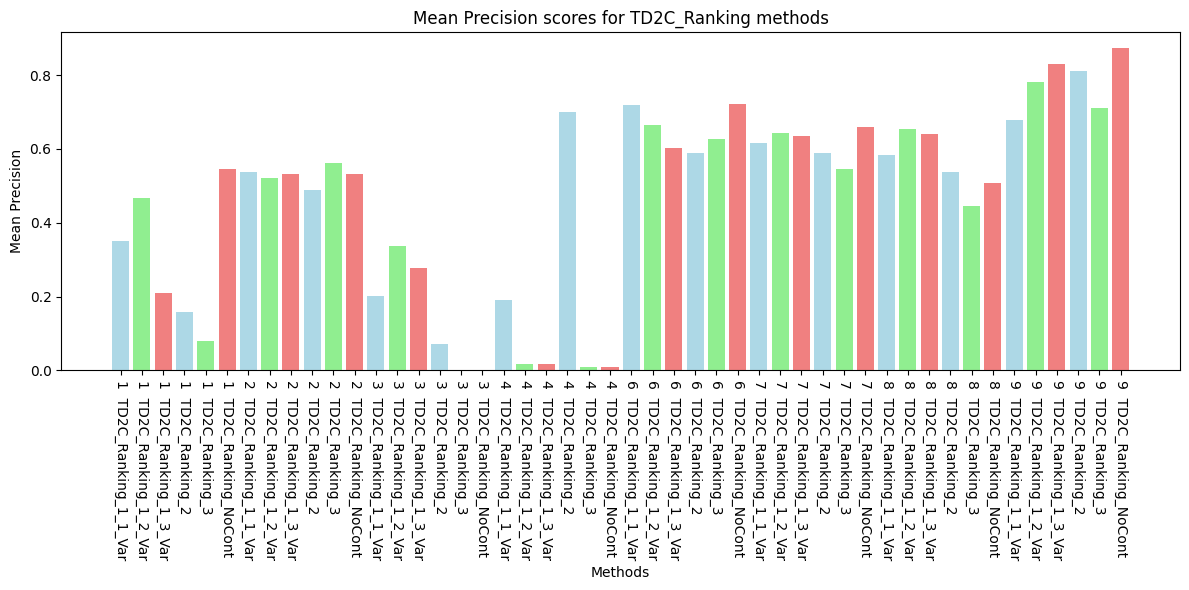

In [87]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))

plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_precision.pdf')

plt.show()

In [89]:
# NOW SHOW THE PRECISION RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
df4 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_2'
df5['method'] = 'TD2C_Ranking_3'
df6['method'] = 'TD2C_Ranking_NoCont'

df = pd.concat([df1, df2, df3, df4, df5, df6])

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='precision')

df['precision'] = df['precision'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='precision')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_Ranking_1_1_Var_precision_process': 'TD2C_Ranking_1_1_Var_precision_process',
                        'TD2C_Ranking_1_2_Var_precision_process': 'TD2C_Ranking_1_2_Var_precision_process',
                        'TD2C_Ranking_1_3_Var_precision_process': 'TD2C_Ranking_1_3_Var_precision_process',
                        'TD2C_Ranking_2_precision_process': 'TD2C_Ranking_2_precision_process',
                        'TD2C_Ranking_3_precision_process': 'TD2C_Ranking_3_precision_process',
                        'TD2C_Ranking_NoCont_precision_process': 'TD2C_Ranking_NoCont_precision_process'})


# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_1545/4248576681.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  \
0                1              0.349766              0.466860   
1                2              0.537127              0.520063   
2                3              0.201667              0.337917   
3                4              0.189980              0.017424   
4                6              0.717775              0.665670   
5                7              0.616098              0.642952   
6                8              0.583592              0.653726   
7                9              0.677827              0.782312   

method  TD2C_Ranking_1_3_Var  TD2C_Ranking_2  TD2C_Ranking_3  \
0                   0.210134        0.157431        0.080754   
1                   0.531612        0.487972        0.561545   
2                   0.276786        0.070833        0.000000   
3                   0.017083        0.700225        0.010000   
4                   0.602064        0.590032        0.625435   
5                   0.634189        0.587871        0.545468   
6                   0.641169        0.537510        0.445405   
7                   0.828712        0.811934        0.709598   

method  TD2C_Ranking_NoCont  
0                  0.544455  
1                  0.533127  
2                  0.000000  
3                  0.010714  
4                  0.720938  
5                  0.657972  
6                  0.508926  
7                  0.871989

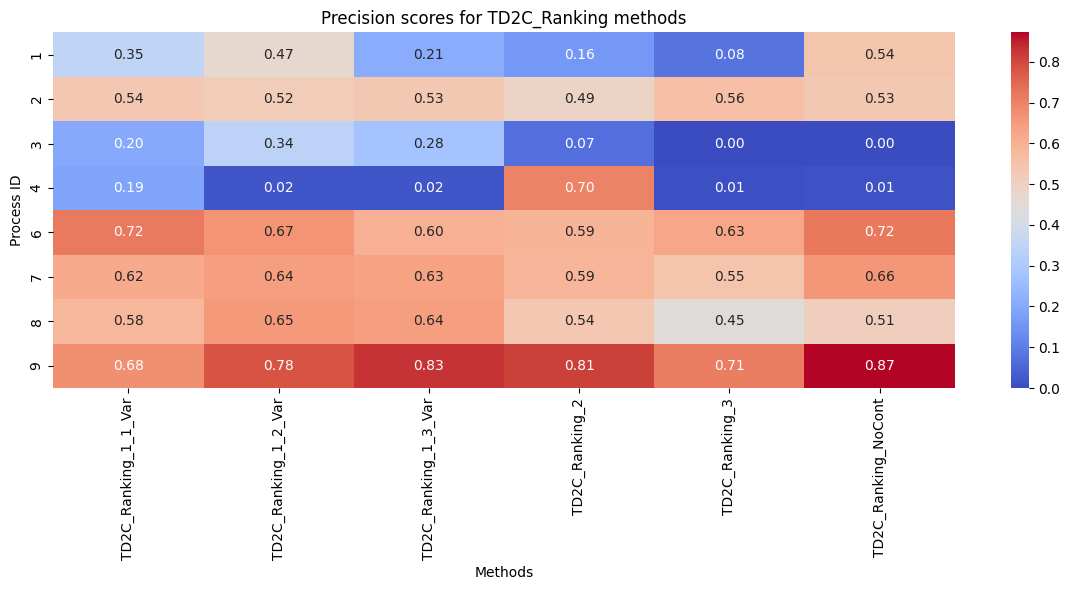

In [109]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Precision scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking_precision.pdf')

plt.show()

In [132]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'precision'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_mean_proc.csv', index=False)

df

Process ID  precision
0           1   0.301567
1           2   0.528574
2           3   0.147867
3           4   0.157571
4           6   0.653652
5           7   0.614092
6           8   0.561721
7           9   0.780395

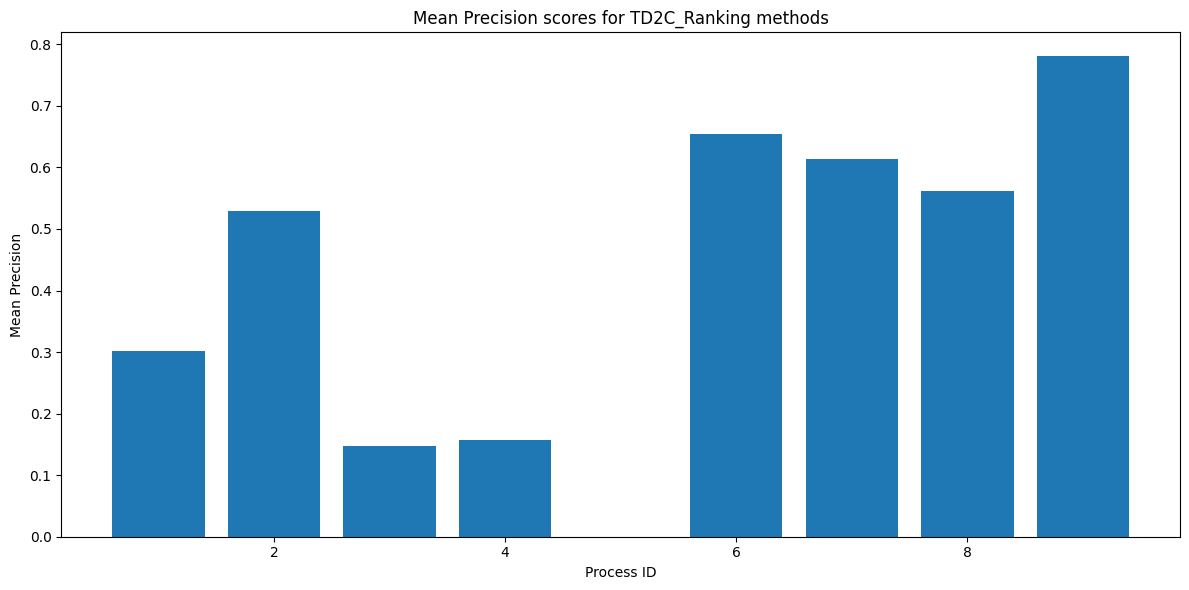

In [138]:
# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['precision'])
plt.title('Mean Precision scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_precision_mean_proc.pdf')

plt.show()


In [90]:
# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'precision'})

df = df.sort_values(by='precision', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_avg.csv', index=False)

df


method  precision
0            Process ID   5.000000
1  TD2C_Ranking_1_2_Var   0.510865
2        TD2C_Ranking_2   0.492976
3  TD2C_Ranking_1_1_Var   0.484229
4   TD2C_Ranking_NoCont   0.481015
5  TD2C_Ranking_1_3_Var   0.467719
6        TD2C_Ranking_3   0.372276

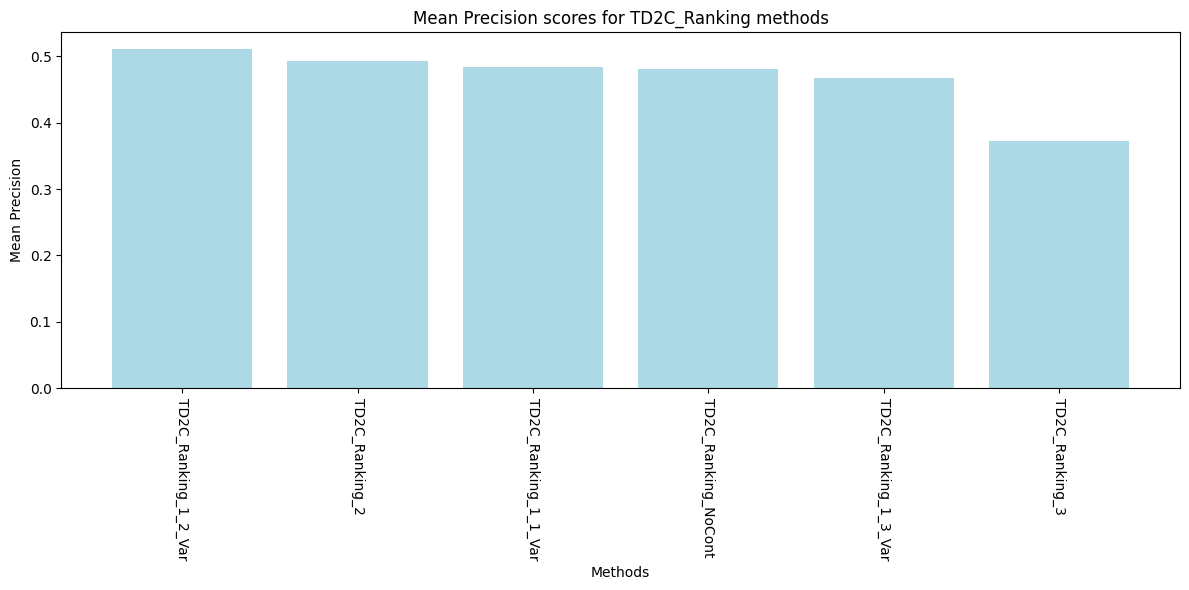

In [92]:
# load the data from csv files
df_prec = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/precision_td2c_ranking_avg.csv')

# Barplot for precision scores from index 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df_prec['method'][1:], df_prec['precision'][1:], color='lightblue')
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_precision_avg.pdf')

plt.show()

#### knnCMI

In [ ]:
df1 = pd.DataFrame(d2c_K_precision_process)
df2 = pd.DataFrame(td2c_K_precision_process)
df3 = pd.DataFrame(td2c_rank_K_precision_process)
# df4 = pd.DataFrame(td2c_past_K_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Precision scores for D2C, TD2C and TD2C+Ranking methods with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

### Recall

#### Regression

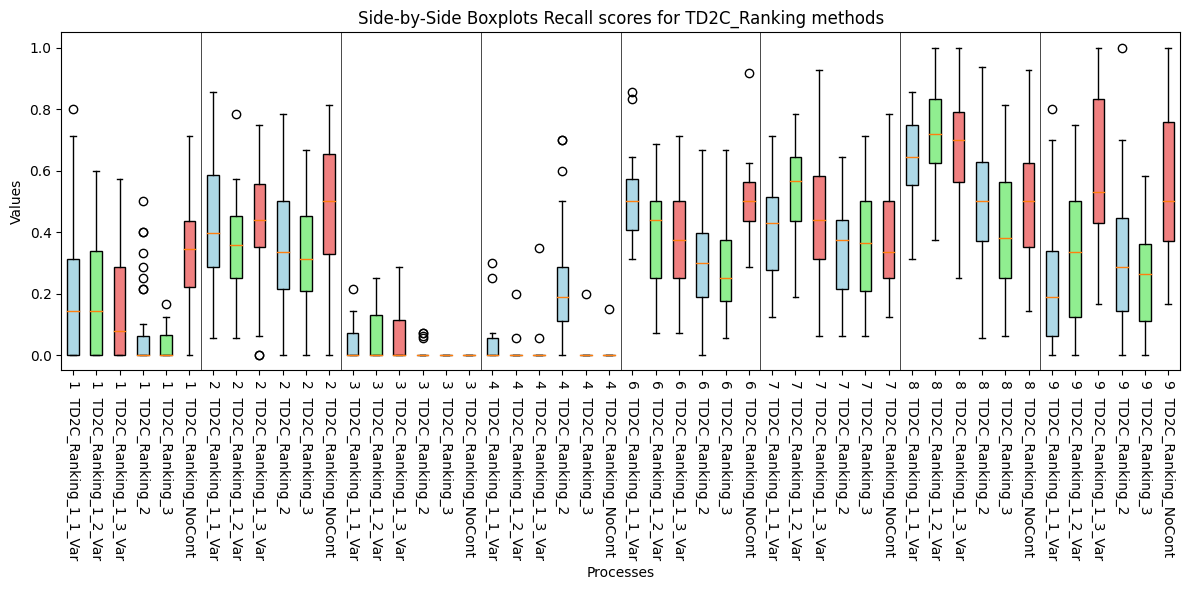

In [93]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
df4 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(6, len(labels), 6):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking_recall.pdf')

plt.show()

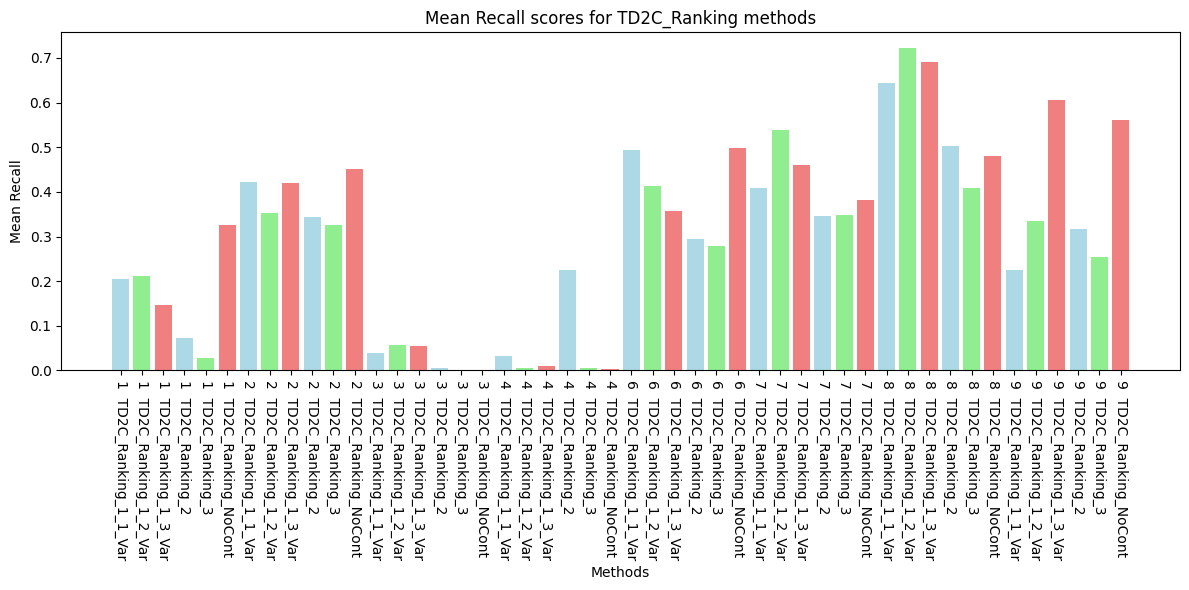

In [95]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))
plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_recall.pdf')

plt.show()

In [94]:
# NOW SHOW THE RECALL RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
df4 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_2'
df5['method'] = 'TD2C_Ranking_3'
df6['method'] = 'TD2C_Ranking_NoCont'

df = pd.concat([df1, df2, df3, df4, df5, df6])

df = df.reset_index()

df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='recall')

df['recall'] = df['recall'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='recall')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_Ranking_1_1_Var_recall_process': 'TD2C_Ranking_1_1_Var_recall_process',
                        'TD2C_Ranking_1_2_Var_recall_process': 'TD2C_Ranking_1_2_Var_recall_process',
                        'TD2C_Ranking_1_3_Var_recall_process': 'TD2C_Ranking_1_3_Var_recall_process',
                        'TD2C_Ranking_2_recall_process': 'TD2C_Ranking_2_recall_process',
                        'TD2C_Ranking_3_recall_process': 'TD2C_Ranking_3_recall_process',
                        'TD2C_Ranking_NoCont_recall_process': 'TD2C_Ranking_NoCont_recall_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_1545/1382164109.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  \
0                1              0.205610              0.211488   
1                2              0.421875              0.352480   
2                3              0.038294              0.057862   
3                4              0.032525              0.006389   
4                6              0.493502              0.413889   
5                7              0.408061              0.539385   
6                8              0.643056              0.721404   
7                9              0.224360              0.335372   

method  TD2C_Ranking_1_3_Var  TD2C_Ranking_2  TD2C_Ranking_3  \
0                   0.147312        0.073690        0.028586   
1                   0.419345        0.343378        0.326587   
2                   0.055580        0.006523        0.000000   
3                   0.010139        0.225561        0.005000   
4                   0.357961        0.295139        0.277927   
5                   0.461012        0.345238        0.349157   
6                   0.690055        0.502604        0.409301   
7                   0.606057        0.317312        0.253313   

method  TD2C_Ranking_NoCont  
0                  0.326265  
1                  0.451463  
2                  0.000000  
3                  0.003750  
4                  0.498859  
5                  0.380903  
6                  0.480952  
7                  0.560263

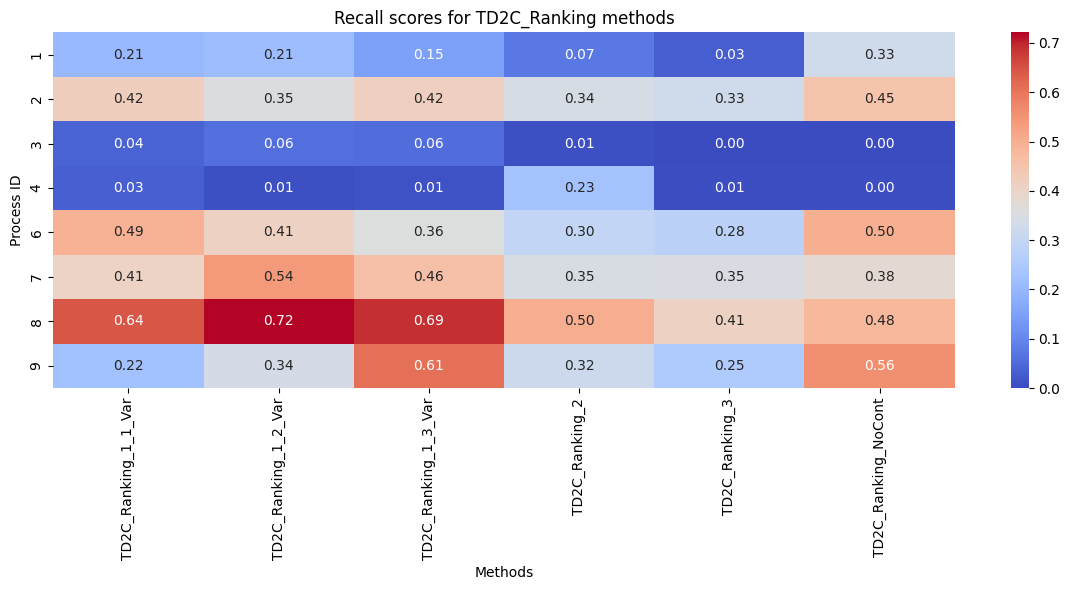

In [110]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Recall scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking_recall.pdf')

plt.show()

In [139]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'recall'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_mean_proc.csv', index=False)

df

Process ID    recall
0           1  0.165492
1           2  0.385855
2           3  0.026376
3           4  0.047227
4           6  0.389546
5           7  0.413959
6           8  0.574562
7           9  0.382779

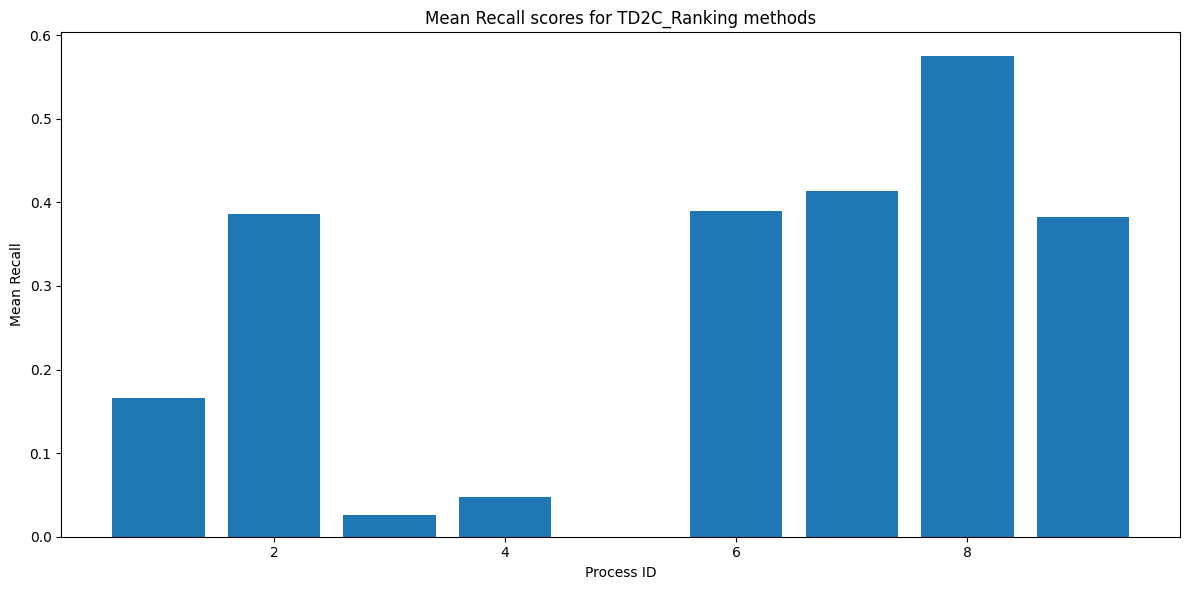

In [140]:
# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['recall'])
plt.title('Mean Recall scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_recall_mean_proc.pdf')

plt.show()

In [96]:
# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'recall'})

df = df.sort_values(by='recall', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_avg.csv', index=False)

df

method    recall
0            Process ID  5.000000
1  TD2C_Ranking_1_3_Var  0.343433
2   TD2C_Ranking_NoCont  0.337807
3  TD2C_Ranking_1_2_Var  0.329784
4  TD2C_Ranking_1_1_Var  0.308410
5        TD2C_Ranking_2  0.263681
6        TD2C_Ranking_3  0.206234

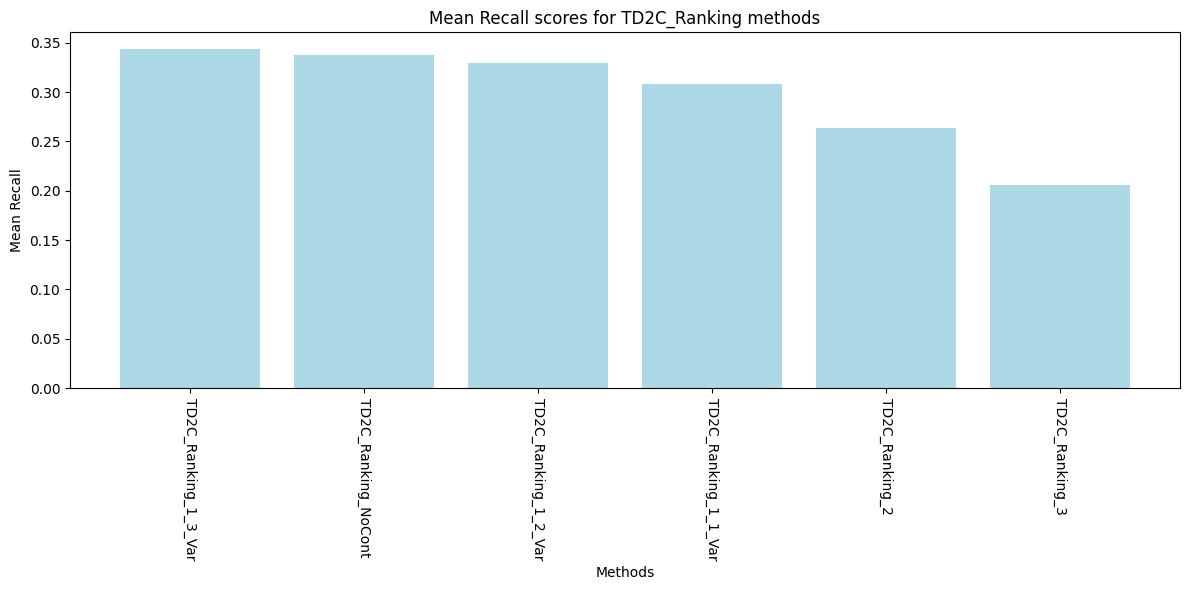

In [97]:
# load the data from csv files
df_recall = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/recall_td2c_ranking_avg.csv')

# Barplot for recall scores from index 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df_recall['method'][1:], df_recall['recall'][1:], color='lightblue')
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_recall_avg.pdf')

plt.show()

#### knnCMI

In [ ]:
df1 = pd.DataFrame(d2c_K_recall_process)
df2 = pd.DataFrame(td2c_K_recall_process)
df3 = pd.DataFrame(td2c_rank_K_recall_process)
# df4 = pd.DataFrame(td2c_past_K_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

### F1

#### Regression

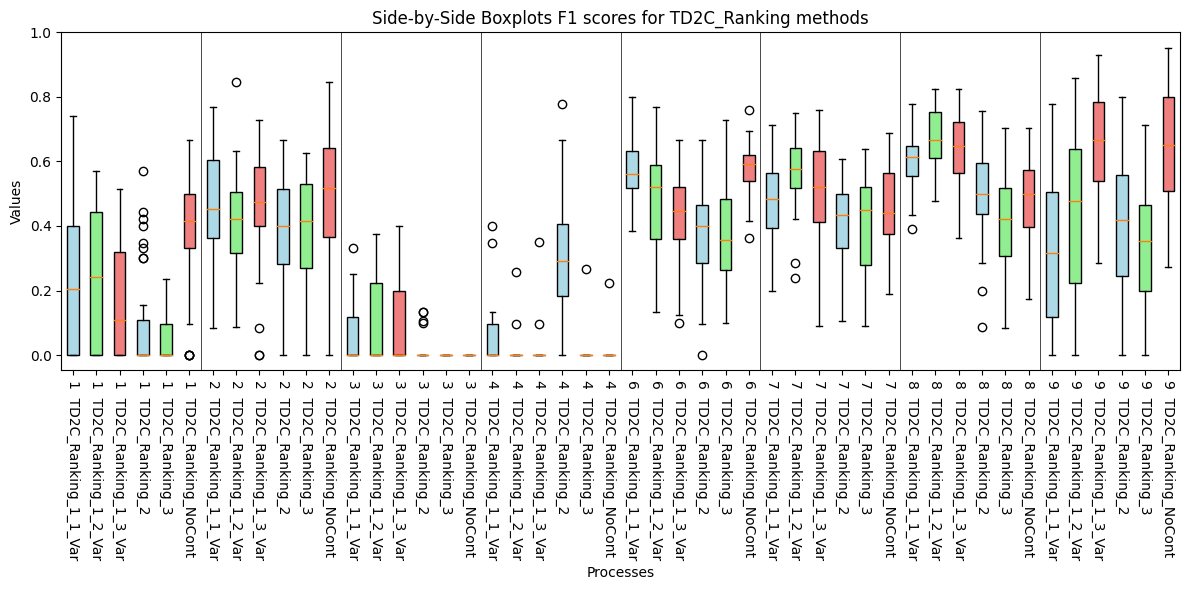

In [98]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
df4 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])

# Create labels for x-axis
labels = []

for col in df1.columns:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_NoCont')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']

for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# add a vertical line every 6 boxes
for i in range(6, len(labels), 6):
    plt.axvline(x=i+0.5, color='black', linewidth=0.5)

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/boxplot_TD2C_Ranking_f1.pdf')

plt.show()


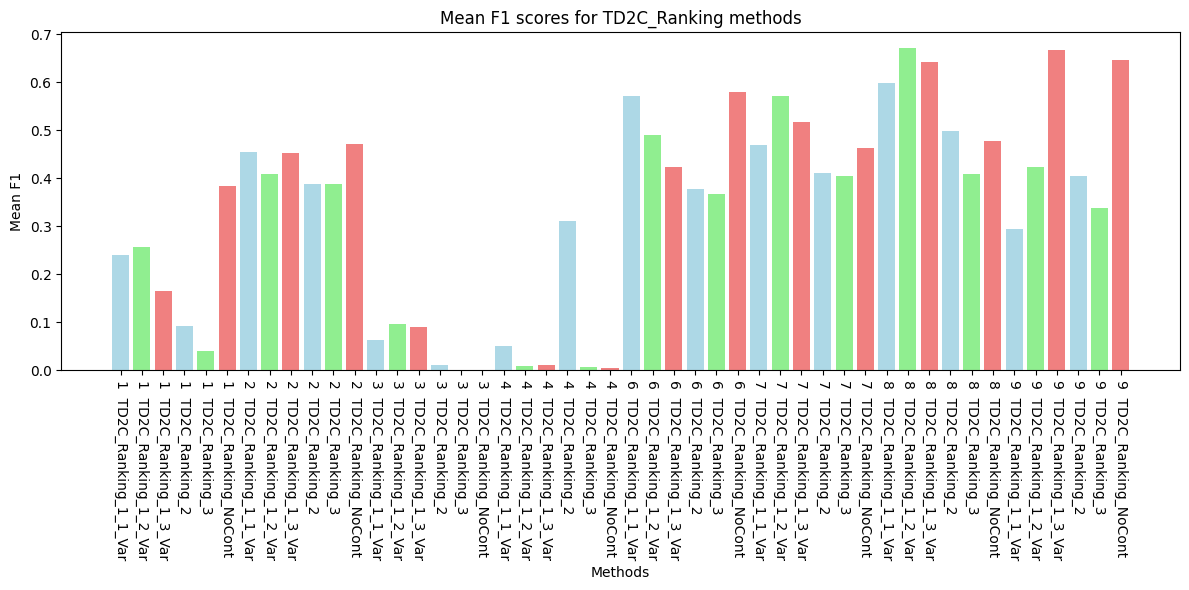

In [99]:
# Plotting Barplot
mean_values = []
for data in combined_data:
    mean_values.append(np.mean(data))

plt.figure(figsize=(12, 6))
plt.bar(labels, mean_values, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_f1.pdf')

plt.show()

In [100]:
# NOW SHOW THE F1 RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
df4 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)

df1 = df1.T
df2 = df2.T
df3 = df3.T
df4 = df4.T
df5 = df5.T
df6 = df6.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
df3['method'] = 'TD2C_Ranking_1_3_Var'
df4['method'] = 'TD2C_Ranking_2'
df5['method'] = 'TD2C_Ranking_3'
df6['method'] = 'TD2C_Ranking_NoCont'

df = pd.concat([df1, df2, df3, df4, df5, df6])

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='f1')

df['f1'] = df['f1'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='f1')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID',
                        'TD2C_Ranking_1_1_Var_f1_process': 'TD2C_Ranking_1_1_Var_f1_process',
                        'TD2C_Ranking_1_2_Var_f1_process': 'TD2C_Ranking_1_2_Var_f1_process',
                        'TD2C_Ranking_1_3_Var_f1_process': 'TD2C_Ranking_1_3_Var_f1_process',
                        'TD2C_Ranking_2_f1_process': 'TD2C_Ranking_2_f1_process',
                        'TD2C_Ranking_3_f1_process': 'TD2C_Ranking_3_f1_process',
                        'TD2C_Ranking_NoCont_f1_process': 'TD2C_Ranking_NoCont_f1_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv', index=False)

df

/tmp/ipykernel_1545/2603610702.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['process_id', 'method']).mean().reset_index()


method  Process ID  TD2C_Ranking_1_1_Var  TD2C_Ranking_1_2_Var  \
0                1              0.239623              0.257405   
1                2              0.455612              0.409353   
2                3              0.063514              0.096275   
3                4              0.050633              0.008833   
4                6              0.571218              0.489654   
5                7              0.470536              0.571569   
6                8              0.598087              0.670822   
7                9              0.295490              0.424840   

method  TD2C_Ranking_1_3_Var  TD2C_Ranking_2  TD2C_Ranking_3  \
0                   0.166167        0.092252        0.041124   
1                   0.453694        0.388329        0.387857   
2                   0.089830        0.011798        0.000000   
3                   0.011131        0.311380        0.006667   
4                   0.424884        0.378811        0.367014   
5                   0.518537        0.411245        0.404092   
6                   0.643279        0.499355        0.409189   
7                   0.667685        0.406126        0.337959   

method  TD2C_Ranking_NoCont  
0                  0.384798  
1                  0.471880  
2                  0.000000  
3                  0.005556  
4                  0.579747  
5                  0.463395  
6                  0.478409  
7                  0.646057

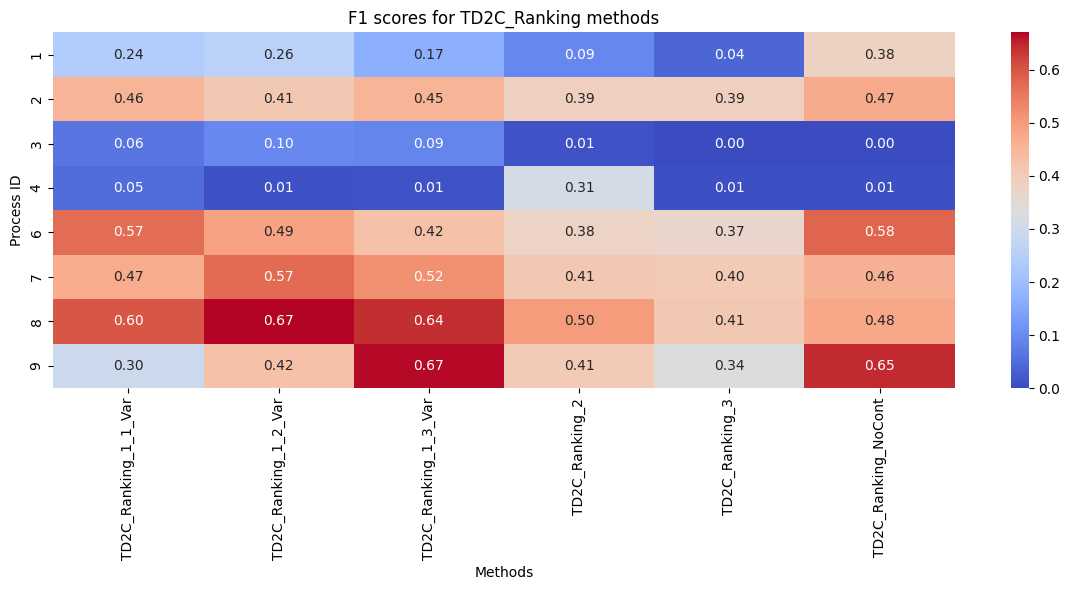

In [111]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('F1 scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/heatmap_TD2C_Ranking_f1.pdf')

plt.show()

In [142]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'f1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_mean_proc.csv', index=False)

df

Process ID        f1
0           1  0.196895
1           2  0.427787
2           3  0.043570
3           4  0.065700
4           6  0.468554
5           7  0.473229
6           8  0.549857
7           9  0.463026

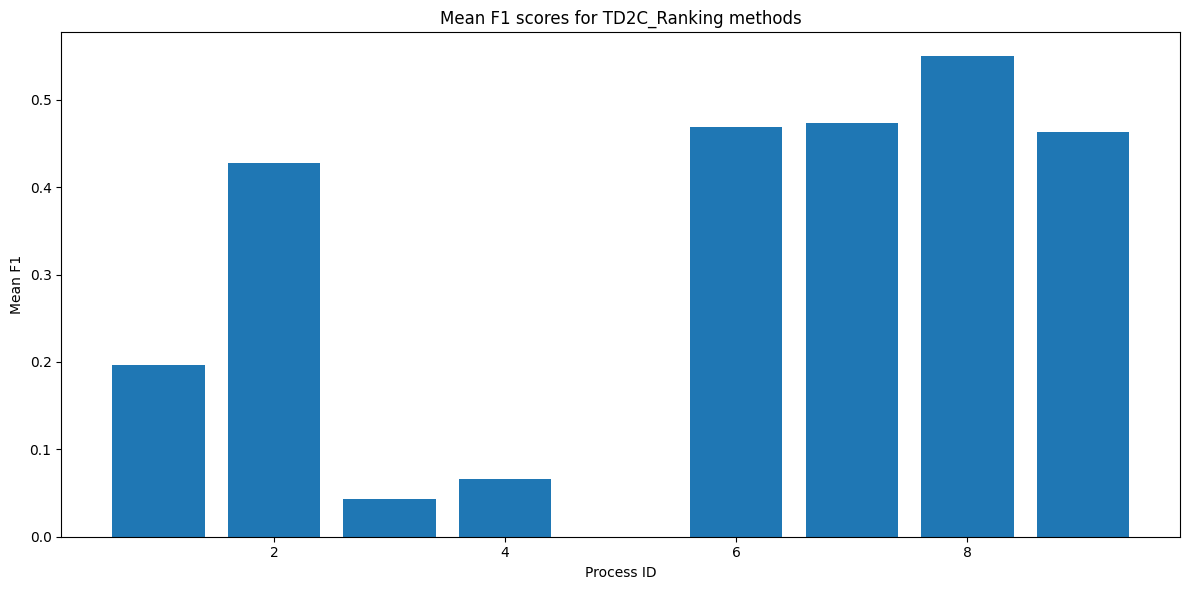

In [143]:
# plot the dataframe as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['f1'])
plt.title('Mean F1 scores for TD2C_Ranking methods')
plt.xlabel('Process ID')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_f1_mean_proc.pdf')

plt.show()

In [101]:
# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'f1'})

df = df.sort_values(by='f1', ascending=False)

df = df.reset_index(drop=True)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_avg.csv', index=False)

df

method        f1
0            Process ID  5.000000
1   TD2C_Ranking_NoCont  0.378730
2  TD2C_Ranking_1_3_Var  0.371901
3  TD2C_Ranking_1_2_Var  0.366094
4  TD2C_Ranking_1_1_Var  0.343089
5        TD2C_Ranking_2  0.312412
6        TD2C_Ranking_3  0.244237

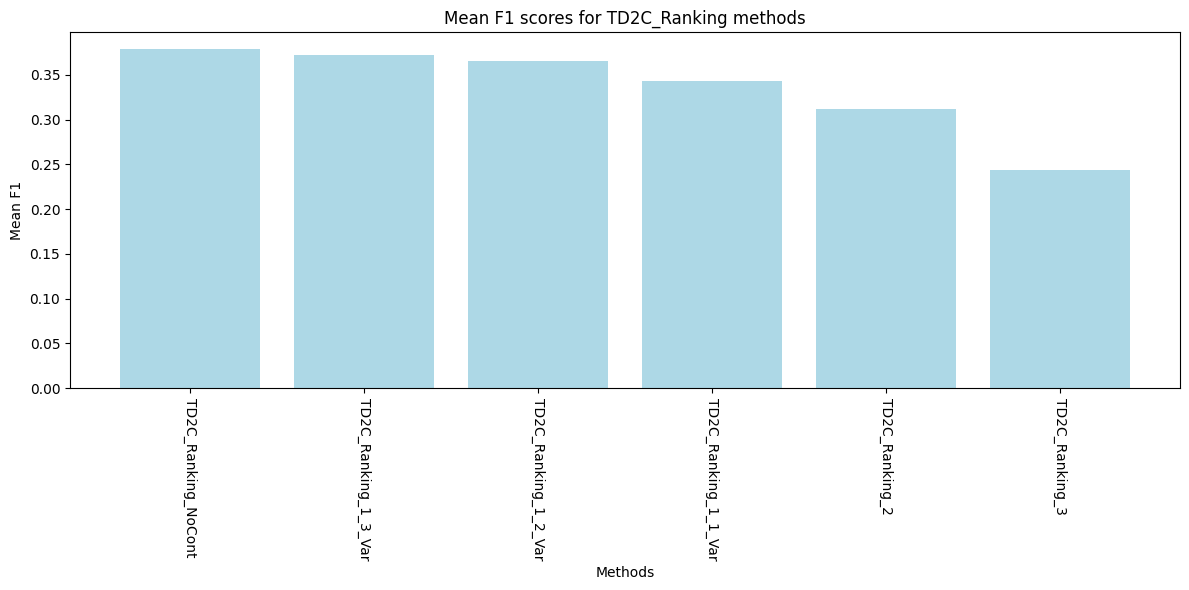

In [102]:
# load the data from csv files
df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/metrics/f1_td2c_ranking_avg.csv')

# Barplot for f1 scores from index 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df_f1['method'][1:], df_f1['f1'][1:], color='lightblue')
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/plots/barplot_TD2C_Ranking_f1_avg.pdf')

plt.show()

#### knnCMI

In [ ]:
df1 = pd.DataFrame(d2c_K_f1_process)
df2 = pd.DataFrame(td2c_K_f1_process)
df3 = pd.DataFrame(td2c_rank_K_f1_process)
# df4 = pd.DataFrame(td2c_past_K_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for F1 scores for D2C, TD2C and TD2C+Ranking methods with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()